# DenseNet
In this notebook, we train a DenseNet classifier for SVHN and CIFAR10 datasets. (https://arxiv.org/abs/1608.06993)

In [7]:
"""
Script adapted from: https://github.com/kuangliu/pytorch-cifar
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('../..')
from models import densenet121

## Dataloader

Here, we load the MNIST dataset, which is provided through torchvision. If you wish to use your own, ...

In [75]:
# Transform from PIL image format to tensor format
transform_train = transforms.Compose([
    # You can add more data augmentation techniques in series: 
    # https://pytorch.org/docs/stable/torchvision/transforms.html
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

# CIFAR10 Dataset: https://www.cs.toronto.edu/~kriz/cifar.html
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)

# SVHN Dataset: http://ufldl.stanford.edu/housenumbers/
# trainset = torchvision.datasets.SVHN(root='../data', split='train', transform=transform_train, download=True)
# testset = torchvision.datasets.SVHN(root='../data', split='test', transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


If making a proof of concept application, we can choose to overfit on a data subset for quick training.

In [77]:
train_ct = 100 # Size of train data
test_ct = 20 # Size of test data
batch_sz = 20
num_workers = 4

if train_ct:
    trainset = data.dataset.Subset(trainset, range(train_ct))

if test_ct:
    testset = data.dataset.Subset(trainset, range(test_ct))

trainloader = data.DataLoader(trainset, batch_size=batch_sz, shuffle=True, num_workers=num_workers, )
testloader = data.DataLoader(testset, batch_size=batch_sz, shuffle=False, num_workers=num_workers)

## Training

Configure model

In [78]:
# This defines 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = densenet121()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net, [0])
    # cudnn.benchmark
    
resume = False # To resume training from saved checkpoint, 

if resume:
    # Load checkpoint.
    print('Resuming from checkpoint at ckpts/best.pth.tar...')
    assert os.path.isdir('ckpts'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('checkpoint/best_model.pth.tar')
    net.load_state_dict(checkpoint['net'])
    global best_loss
    best_loss = checkpoint['test_loss']
    start_epoch = checkpoint['epoch']
    
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.1)

In [79]:
def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    with tqdm(total=len(trainloader.dataset)) as progress_bar:
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            acc = f'{(100. * correct / total)}%'
        
            progress_bar.set_postfix(loss=train_loss/(batch_idx+1), accuracy=acc)
            progress_bar.update(inputs.size(0))
            
        
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    best_acc = 0
    with torch.no_grad():
        with tqdm(total=len(testloader.dataset)) as progress_bar:
            for batch_idx, (inputs, targets) in enumerate(testloader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = net(inputs)
                loss = loss_fn(outputs, targets)
            
                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
                
                acc = (100. * correct / total)
                progress_bar.set_postfix(loss=test_loss/(batch_idx+1), accuracy=f'{acc}%')
                progress_bar.update(inputs.size(0))
                
                # Early stopping
                if acc > best_acc:
                    print("Saving...")
                    save_state(net, acc, epoch)
                    best_acc = acc

def save_state(net, acc, epoch):
    state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/best_model.pth.tar')

In [80]:
for epoch in range(0, 100):
    train(epoch)
    test(epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


  0%|          | 0/100 [00:00<?, ?it/s]

Saving...


 40%|████      | 40/100 [00:01<00:02, 25.89it/s, accuracy=57.5%, loss=1.38]
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aqua/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/aqua/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/aqua/miniconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/aqua/miniconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/aqua/miniconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/aqua/miniconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._se

KeyboardInterrupt: 

## Inference
Now that we have trained a model, we can use it for inference on new data!

In [81]:
def classify_image(x):
    outputs = net(x)
    _, predicted = outputs.max(1)
    return predicted

Predicted class: 9


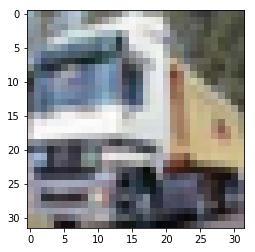

In [83]:
cp = torch.load('./checkpoint/best_model.pth.tar')
net.load_state_dict(cp['net'])
net.eval()
sample = trainset[1][0]
plt.imshow(sample.permute(1,2,0))

y = classify_image(sample.unsqueeze(0))[0]
print(f'Predicted class: {y}')

(If you are running on CIFAR, you can get the associated class labels at https://www.cs.toronto.edu/~kriz/cifar.html.
0 = airplane, 1 = automobile, etc.)

## Export (API)
We want to be able to use our models inside our apps. One way to do this is to wrap our calls with a web API.

How to make this general: Create a generic model api that takes input and returns output.

## Export (CoreML)